In [3]:
import numpy as np
import csv
import cvxpy as cp #convex optimization
import matplotlib.pyplot as plt 
import argparse
import time

## Experiment Setting (for instance)
- 96 operation steps: 15 min/step, total 24 hours
- Power Capacity $\bar{P}$: the total power of charging station can delivery at one time step, 12kW -> 3/step
- SoC $x$: the percents of energy of vehicle
- Full Battery energy of vehicle $B$, 8 kWh
- Rated Battery Power $\bar{u}$: 1.6 kW -> 0.4/step

In [6]:
num_steps = 96
total_vehicles = 50
battery_capacity = 8
power_capacity = 3
max_power_u = 0.4

dataset = generate_dataset(num_step=num_steps, total_vehicles=total_vehicles, battery_capacity=battery_capacity)
carbon_intensity = dataset['carbon_intensity']
arrival_time = dataset['arrival_time']
depart_time = dataset['depart_time']
initial_state = dataset['initial_state']
final_energy = dataset['final_energy']
required_energy = dataset['required_energy']

arrival time:25.0


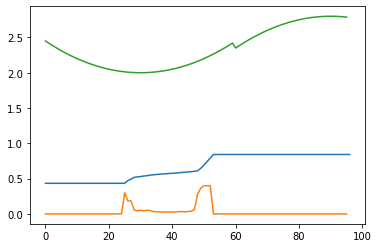

the energy delivery: 151.55, the required energy: 194.73, the carbon emission term: 331.49


In [20]:
x, u = carbon_aware_MPC(carbon_intensity, total_vehicles, num_steps, initial_state, max_power_u, final_energy, arrival_time, depart_time, power_capacity,battery_capacity,factor=30)
carbon_emission = np.sum(np.array([u[:,t]*carbon_intensity[t] for t in range(num_steps)]))
print(f'the energy delivery: {round(np.sum(u),2)}, the required energy: {round(np.sum(required_energy),2)}, the carbon emission term: {round(carbon_emission,2)}')

arrival time:25.0


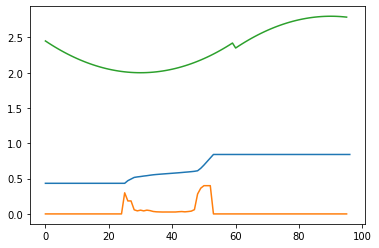

the energy delivery: 157.67, the required energy: 194.73, the carbon emission term: 347.38


In [19]:
x, u = carbon_aware_MPC(carbon_intensity, total_vehicles, num_steps, initial_state, max_power_u, final_energy, arrival_time, depart_time, power_capacity, battery_capacity, factor=60)
carbon_emission = np.sum(np.array([u[:,t]*carbon_intensity[t] for t in range(num_steps)]))
print(f'the energy delivery: {round(np.sum(u),2)}, the required energy: {round(np.sum(required_energy),2)}, the carbon emission term: {round(carbon_emission,2)}')

In [18]:
def generate_dataset(num_step=96, total_vehicles=100, battery_capacity = 8, lam=9, seed=0):
    np.random.seed(seed)
    arrival_time= np.random.poisson(lam=lam, size=(total_vehicles,))
    arrival_time = np.sort(arrival_time)*4.0
    arrival_time = arrival_time + np.random.randint(0,4, size=(total_vehicles,))
    arrival_time = np.sort(arrival_time)
    depart_time = np.random.randint(6, 36, size=(total_vehicles,))
    depart_time = np.min((arrival_time+depart_time, np.ones_like(arrival_time)*num_step), axis=0)
    
    initial_state=np.random.uniform(0.8, 4.0, size=(total_vehicles,))
    required_energy=np.random.uniform(2.0, 6.0, size=(total_vehicles,))
    final_energy = np.min((initial_state+required_energy, np.ones_like(initial_state)*battery_capacity), axis=0)
    required_energy = np.round(final_energy-initial_state, 2)
    
    carbon_intensity = np.array([0.005*(t-40)**2 + 20 for t in range(60)] + [-0.005*(t-30)**2 + 28 for t in range(36)]) / 10
    dataset = {'carbon_intensity':carbon_intensity, 'arrival_time':arrival_time, 'depart_time':depart_time, 'initial_state':initial_state, 'required_energy': required_energy, 'final_energy':final_energy}
    
    return dataset


def carbon_aware_MPC(carbon_intensity, num_of_vehicles, timesteps, initial_states, max_power, terminal_states, arrival_time, dept_time, power_capacity, B, factor = 1):
    x_terminal=cp.Parameter(num_of_vehicles, name='x_terminal') # Requested end SoC for all vehicles
    x0 = cp.Parameter(num_of_vehicles, name='x0') # Initial SoC for all vehicles
    max_sum_u = cp.Parameter(name='max_sum_u') # Peak charging power for the infrastructure
    u_max = cp.Parameter(name='u_max') # Maximum charging power for each vehicle at each time step
    
    x = cp.Variable((num_of_vehicles, timesteps+1), name='x') # SoC at each time step for each vehicle
    u = cp.Variable((num_of_vehicles, timesteps), name='u') # charging power at each time step for each vehicle

    x_terminal.value=terminal_states
    x0.value = initial_states
    max_sum_u.value = power_capacity
    u_max.value = max_power

    constr = [x[:,0] == x0,  x[:,-1] <= x_terminal]

    for i in range(num_of_vehicles):
        constr += [x[i,1:] == x[i,0:timesteps] + u[i,:], u[i,:] >= 0,]
        for t in range(timesteps):
            constr += [u[i, t] <= u_max*(t>=arrival_time[i]),
                       u[i, t] <= u_max*(t<dept_time[i])]
    obj = 0.
    for t in range (timesteps):
        constr += [cp.sum(u[0:num_of_vehicles,t]) <= power_capacity]
        obj += cp.sum(u[:,t]*carbon_intensity[t])

    obj += factor * cp.norm(x[:, -1] - x_terminal, 2)
    prob = cp.Problem(cp.Minimize(obj), constr)
    prob.solve()

    plt.plot(x.value[10]/B,label='SoC')
    plt.plot(u.value[10],label='charging_power')
    plt.plot(carbon_intensity,label='carbon_intensity')
    print(f'arrival time:{arrival_time[10]}')
    plt.show()

    return x.value/B, u.value